### Filtering Alerts

Here are some examples of filtering alerts based on the packet contents.

In [61]:
import os
import io
import gzip
import tarfile
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter
import fastavro

from astropy.time import Time
from astropy.io import fits
import astropy.units as u
import aplpy
%matplotlib inline

Tar archives of ZTF alerts are available from https://ztf.uw.edu/public/alerts.  Let's extract to a directory:

In [62]:
#NOTE:
#ztf_public_20181215 has not transient alerts = not applicable as example
#ztf_public_20180601 has transient alerts
#

tar_archive = 'D:/@Seattle/data/ztf_public_20180626.tar.gz'
#output_dir = tar_archive.split('/')[-1].split('.')[-3]
output_dir = 'D:/@Seattle/data/ztf_public_20180626'

In [63]:
#archive = tarfile.open(tar_archive,'r:gz')
#archive.extractall(path=output_dir)
#archive.close()

Let's count packets.

In [64]:
def find_files(root_dir):
    for dir_name, subdir_list, file_list in os.walk(root_dir, followlinks=True):
        for fname in file_list:
            if fname.endswith('.avro'):
                yield dir_name+'/'+fname

In [65]:
print('{} has {} avro files'.format(output_dir, len(list(find_files(output_dir)))))

D:/@Seattle/data/ztf_public_20180626 has 23553 avro files


In [66]:
def open_avro(fname):
    with open(fname,'rb') as f:
        freader = fastavro.reader(f)
        # in principle there can be multiple packets per file
        for packet in freader:
            yield packet

In [67]:
def generate_dictionaries(root_dir):
    for fname in find_files(root_dir):
        for packet in open_avro(fname):
            yield packet

Let's count the number of observations by program (should all be public!).  Reviewing the [alert packet contents](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html), we want the `programid` field in `candidate`.

In [68]:
%%time
from collections import defaultdict
programs = defaultdict(int)
for packet in generate_dictionaries(output_dir):
    programs[packet['candidate']['programid']] += 1
print(programs)

defaultdict(<class 'int'>, {1: 23553})
Wall time: 2min 38s


The alert archive is a fairly raw stream.  Users desiring greater purity can apply the [suggested filters](https://zwickytransientfacility.github.io/ztf-avro-alert/filtering.html):

```
rb >= 0.65 and
nbad = 0 and
fwhm <= 5 and
elong <= 1.2 and
abs(magdiff) <= 0.1
```

In [69]:
def is_alert_pure(packet):
    pure = True
    pure &= packet['candidate']['rb'] >= 0.65
    pure &= packet['candidate']['nbad'] == 0
    pure &= packet['candidate']['fwhm'] <= 5
    pure &= packet['candidate']['elong'] <= 12
    pure &= np.abs(packet['candidate']['magdiff']) <= 0.1
    return pure

Let's count the purified packets:

In [70]:
%%time
programs = defaultdict(int)
for packet in filter(is_alert_pure,generate_dictionaries(output_dir)):
    programs[packet['candidate']['programid']] += 1
print(programs)

defaultdict(<class 'int'>, {1: 4706})
Wall time: 30.6 s


For applications using lightcurves it's useful to have the data in a dataframe, but this construction is somewhat slower, so let's apply it after our initial filter.

In [71]:
def make_dataframe(packet):
    dfc = pd.DataFrame(packet['candidate'], index=[0])
    df_prv = pd.DataFrame(packet['prv_candidates'])
    dflc = pd.concat([dfc,df_prv], ignore_index=True,sort=True)
    # we'll attach some metadata--not this may not be preserved after all operations
    # https://stackoverflow.com/questions/14688306/adding-meta-information-metadata-to-pandas-dataframe
    dflc.objectId = packet['objectId']
    dflc.candid = packet['candid']
    return dflc

In [72]:
#Mikha's notes
""" how do df index work"""
a = [1,2,3,4,5]
z = pd.DataFrame(a)#,index=[0])
z = pd.DataFrame(a)#,index=[0])
print(z)

   0
0  1
1  2
2  3
3  4
4  5


Let's use the following cuts to select likely extragalactic transients:

* the difference image detection should be positive
* if there is a PS1 source within 1.5" of the source, it should have a star-galaxy score of < 0.5 (galaxy-like)
* there should be at least two detections separated by more than 30 minutes
* there should be no known solar system object within 5"

In [73]:
def is_transient(dflc):
    
    candidate = dflc.loc[0]
    
    is_positive_sub = candidate['isdiffpos'] == 't'
    
    if (candidate['distpsnr1'] is None) or (candidate['distpsnr1'] > 1.5):
        no_pointsource_counterpart = True
    else:
        if candidate['sgscore1'] < 0.5:
            no_pointsource_counterpart = True
        else:
            no_pointsource_counterpart = False
            
    where_detected = (dflc['isdiffpos'] == 't') # nondetections will be None
    if np.sum(where_detected) >= 2:
        detection_times = dflc.loc[where_detected,'jd'].values
        dt = np.diff(detection_times)
        not_moving = np.max(dt) >= (30*u.minute).to(u.day).value
    else:
        not_moving = False
    
    no_ssobject = (candidate['ssdistnr'] is None) or (candidate['ssdistnr'] < 0) or (candidate['ssdistnr'] > 5)
    
    return is_positive_sub and no_pointsource_counterpart and not_moving and no_ssobject

In [75]:
%%time
transient_alerts = []
for packet in filter(is_alert_pure,generate_dictionaries(output_dir)):
    dflc = make_dataframe(packet)
    if is_transient(dflc):
        print(packet['objectId'])
        transient_alerts.append(packet)
        
print('{} has {} transient alerts'.format(output_dir, len(transient_alerts)))

ZTF18aaklvii
ZTF18aaqdmih
ZTF18aaxkfos
ZTF18aarcchg
ZTF18aasufva
ZTF18abafvbk
ZTF18aayivxm
ZTF18aaklvii
ZTF18aahuxsj
ZTF18aauxzle
ZTF18abbwvmb
ZTF18abaamdp
ZTF18aazayzm
ZTF18abaamnb
ZTF18aavlkzu
ZTF18aaytovs
ZTF18aaxjeiz
ZTF18abcofta
ZTF18abctymx
ZTF18abcodnw
ZTF18abcgoiv
ZTF18abbsogf
ZTF18abcgppy
ZTF18aazfebt
ZTF18ababqbp
ZTF18aazddqi
ZTF18aawacgn
ZTF18aaydzjl
ZTF18abclcak
ZTF18abapxee
D:/@Seattle/data/ztf_public_20180626 has 30 transient alerts
Wall time: 1min 50s


In [51]:
#Mikha's notes, where is the obj ID??? DO NOT RUN THIS
"""
for packet in filter(is_alert_pure,generate_dictionaries(output_dir)):
    dflc = make_dataframe(packet)
    print(packet['objectId'])
    
"""

ZTF17aacnkaw
ZTF18aaxlvxx
ZTF18aabpmzg
ZTF18aaccpyz
ZTF18aabpmua
ZTF18aaxlvva
ZTF18aaxlvul
ZTF18aamtkoa
ZTF18aaxlwjm
ZTF18aabycuw
ZTF18aabycsj
ZTF18aaxlvwy
ZTF17aabwnym
ZTF18aaxlweb
ZTF18aaxlwec
ZTF18aabpmxz
ZTF18aaxlwmg
ZTF18aaxlwly
ZTF17aacoegn
ZTF17aacngfc
ZTF17aacmyic
ZTF18aaxlvxn
ZTF18aaxlvxm
ZTF18aaxlwge
ZTF17aacnkbw
ZTF18aaxlwib
ZTF18aaxlwju
ZTF18aabvlxk
ZTF18aabvlxl
ZTF18aaxlwmu
ZTF18aaxlwot
ZTF18aamtkuy
ZTF18aabqqwo
ZTF17aaapvjl
ZTF18aaxlweq
ZTF18aaxlwhp
ZTF18aaxlwht
ZTF18aaxlwyp
ZTF18aaxlwyn
ZTF17aacmyfs
ZTF17aaaplxn
ZTF17aaapvkc
ZTF17aacnjdr
ZTF18aaxlwfq
ZTF18aavnxmg
ZTF18aaxlwfr
ZTF18aaxlwix
ZTF17aacmyfb
ZTF18aaxlwiz
ZTF18aaxlwkc
ZTF17aabucib
ZTF18aaxlwkd
ZTF17aaapmar
ZTF18aaxlwsm
ZTF18aaxlwsd
ZTF18aaxlvvi
ZTF18aabqpiq
ZTF18aabvkov
ZTF18aaxlwba
ZTF18aaqdich
ZTF18aacbuof
ZTF18aaxlvzx
ZTF17aacnjgv
ZTF18aabpsrq
ZTF18aacbogn
ZTF17aabufic
ZTF18aaiiyjn
ZTF18aaxlvzo
ZTF18aaxlvzl
ZTF18aaxlvzm
ZTF18aaxlvzn
ZTF18aaxlwcr
ZTF18aabtsuc
ZTF18aaxlwbd
ZTF18aaxlwbf
ZTF18aaxlvwu
ZTF17aacnjyl

KeyboardInterrupt: 

Now let's do the same thing and make plots instead:

In [76]:
def plot_lightcurve(dflc, ax=None, days_ago=True):
    
    filter_color = {1:'green', 2:'red', 3:'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now
        xlabel = 'Days Ago'
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'
    
    if ax is None:
        plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'magpsf'], dflc.loc[w,'sigmapsf'],fmt='.',color=color)
        wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        if np.sum(wnodet):
            plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')
    plt.title(dflc.objectId)
    

In [77]:
def plot_cutout(stamp, fig=None, subplot=None, **kwargs):
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            if fig is None:
                fig = plt.figure(figsize=(4,4))
            if subplot is None:
                subplot = (1,1,1)
            ffig = aplpy.FITSFigure(hdul[0],figure=fig, subplot=subplot, **kwargs)
            ffig.show_grayscale(stretch='arcsinh')
    return ffig

Now let's make a nice helper function:

In [78]:
def show_stamps(packet):
    #fig, axes = plt.subplots(1,3, figsize=(12,4))
    fig = plt.figure(figsize=(12,4))
    for i, cutout in enumerate(['Science','Template','Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot = (1,3,i+1))
        ffig.set_title(cutout)

In [79]:
def show_all(packet):
    fig = plt.figure(figsize=(16,4))
    dflc = make_dataframe(packet)
    plot_lightcurve(dflc,ax = plt.subplot(1,4,1))
    for i, cutout in enumerate(['Science','Template','Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot = (1,4,i+2))
        ffig.set_title(cutout)

INFO: Auto-setting vmin to  4.201e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.304e+02 [aplpy.core]


INFO: Auto-setting vmin to  7.179e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.144e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.988e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.452e+01 [aplpy.core]


INFO: Auto-setting vmin to  7.438e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.612e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.067e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.406e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.469e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.659e+01 [aplpy.core]


INFO: Auto-setting vmin to  4.913e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.335e+02 [aplpy.core]


INFO: Auto-setting vmin to  8.337e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.144e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.492e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.676e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.494e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.775e+02 [aplpy.core]
INFO: Auto-setting vmin to  1.791e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.620e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.044e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.718e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.624e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.837e+02 [aplpy.core]
INFO: Auto-setting vmin to  1.940e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.410e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.393e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.035e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.635e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.564e+02 [aplpy.core]
INFO: Auto-setting vmin to  1.989e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.559e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.759e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.776e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.983e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.177e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.273e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.870e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.831e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.444e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.698e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.624e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.986e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.517e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.985e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.102e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.992e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.132e+02 [aplpy.core]
INFO: Auto-setting vmin to  2.248e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.993e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.805e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.341e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.781e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.749e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.999e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.556e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.553e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.920e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.713e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.659e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.976e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.328e+03 [aplpy.core]


INFO: Auto-setting vmin to -4.074e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.064e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.788e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.086e+03 [aplpy.core]


INFO: Auto-setting vmin to  2.116e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.128e+03 [aplpy.core]


INFO: Auto-setting vmin to -8.225e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.345e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.797e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.144e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.105e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.674e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.448e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.202e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.650e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.586e+02 [aplpy.core]
INFO: Auto-setting vmin to  1.927e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.346e+02 [aplpy.core]


INFO: Auto-setting vmin to -5.708e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.777e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.563e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.863e+03 [aplpy.core]


INFO: Auto-setting vmin to  2.769e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.702e+03 [aplpy.core]


INFO: Auto-setting vmin to -1.568e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.818e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.422e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.805e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.654e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.026e+02 [aplpy.core]


INFO: Auto-setting vmin to -4.131e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.115e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.262e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.942e+03 [aplpy.core]


INFO: Auto-setting vmin to  2.456e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.914e+03 [aplpy.core]


INFO: Auto-setting vmin to -5.743e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.739e+02 [aplpy.core]


INFO: Auto-setting vmin to  7.067e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.131e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.077e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.104e+03 [aplpy.core]


INFO: Auto-setting vmin to -4.625e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.222e+02 [aplpy.core]


INFO: Auto-setting vmin to  7.741e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.749e+03 [aplpy.core]
INFO: Auto-setting vmin to  1.109e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.902e+03 [aplpy.core]


INFO: Auto-setting vmin to -1.013e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.258e+02 [aplpy.core]


INFO: Auto-setting vmin to  7.994e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.002e+04 [aplpy.core]


INFO: Auto-setting vmin to  1.108e+02 [aplpy.core]
INFO: Auto-setting vmax to  9.936e+03 [aplpy.core]


INFO: Auto-setting vmin to -2.145e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.910e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.296e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.100e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.351e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.103e+03 [aplpy.core]


INFO: Auto-setting vmin to -5.356e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.500e+02 [aplpy.core]


INFO: Auto-setting vmin to  7.274e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.165e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.014e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.465e+03 [aplpy.core]


INFO: Auto-setting vmin to -7.080e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.053e+02 [aplpy.core]


INFO: Auto-setting vmin to  6.436e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.067e+02 [aplpy.core]
INFO: Auto-setting vmin to  9.863e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.830e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.823e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.500e+01 [aplpy.core]


INFO: Auto-setting vmin to  9.321e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.746e+03 [aplpy.core]
INFO: Auto-setting vmin to  1.237e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.936e+03 [aplpy.core]


INFO: Auto-setting vmin to -4.755e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.369e+01 [aplpy.core]


INFO: Auto-setting vmin to  6.617e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.162e+02 [aplpy.core]
INFO: Auto-setting vmin to  9.666e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.291e+02 [aplpy.core]


INFO: Auto-setting vmin to -4.131e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.385e+02 [aplpy.core]


INFO: Auto-setting vmin to  6.497e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.159e+02 [aplpy.core]
INFO: Auto-setting vmin to  9.469e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.238e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.563e+01 [aplpy.core]
INFO: Auto-setting vmax to  9.639e+01 [aplpy.core]


INFO: Auto-setting vmin to  9.525e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.493e+03 [aplpy.core]
INFO: Auto-setting vmin to  1.217e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.440e+03 [aplpy.core]


INFO: Auto-setting vmin to -4.798e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.343e+01 [aplpy.core]


INFO: Auto-setting vmin to  9.964e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.971e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.348e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.310e+02 [aplpy.core]


INFO: Auto-setting vmin to -4.515e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.811e+01 [aplpy.core]


INFO: Auto-setting vmin to  6.454e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.336e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.090e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.824e+02 [aplpy.core]


INFO: Auto-setting vmin to -4.480e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.827e+01 [aplpy.core]


INFO: Auto-setting vmin to  6.427e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.718e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.076e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.191e+02 [aplpy.core]


INFO: Auto-setting vmin to -4.861e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.203e+02 [aplpy.core]


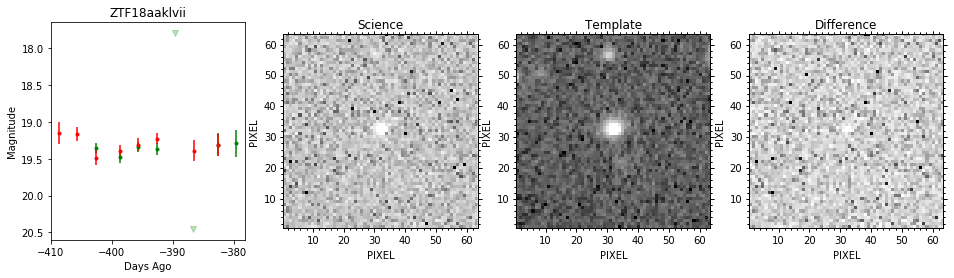

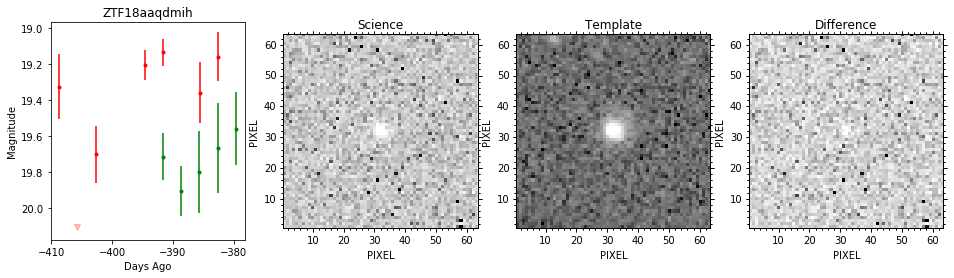

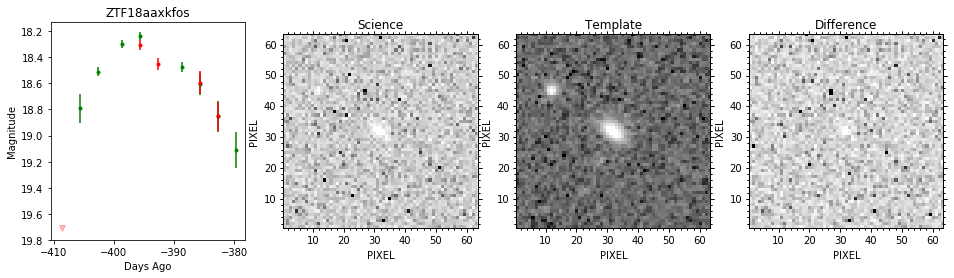

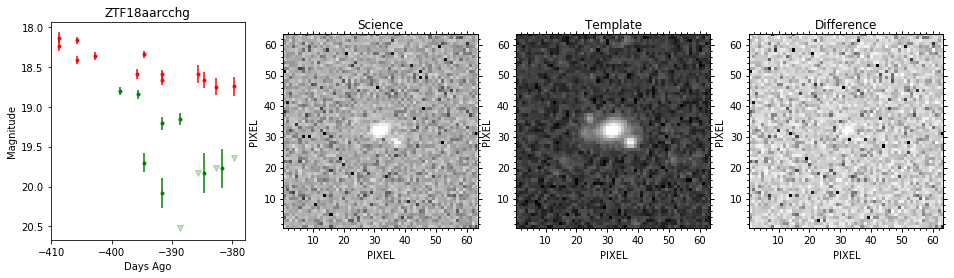

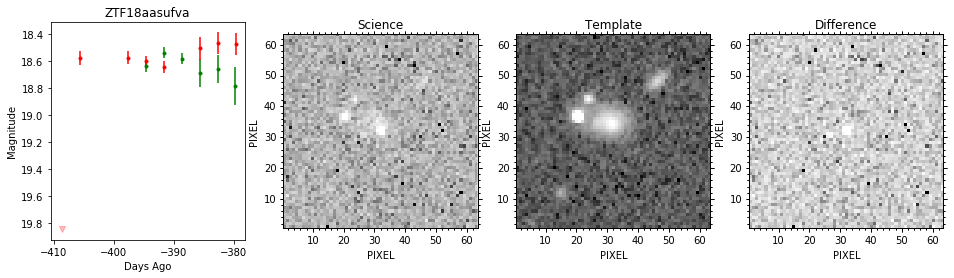

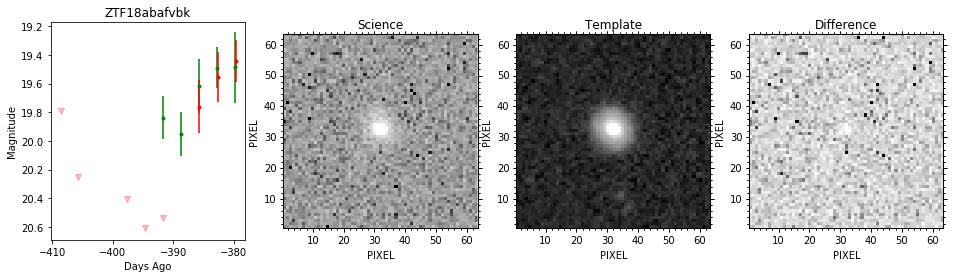

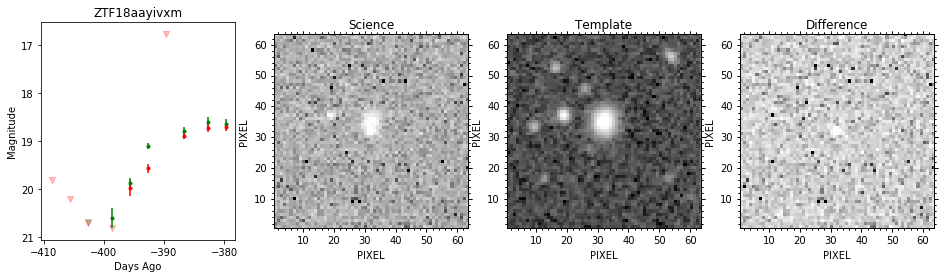

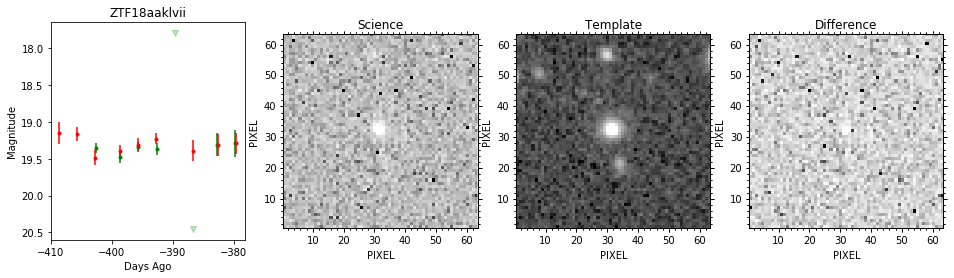

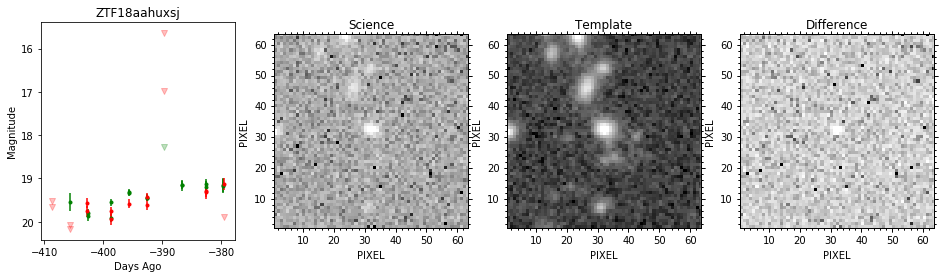

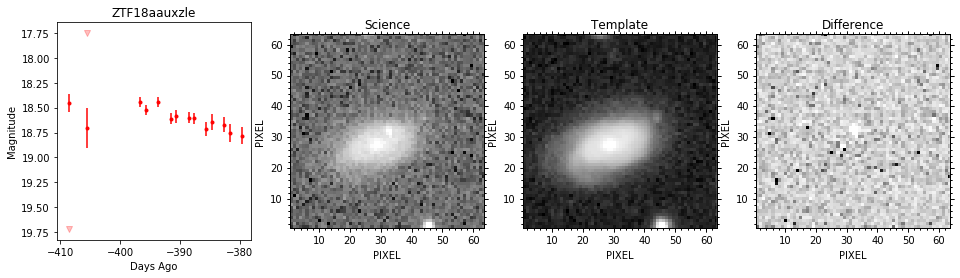

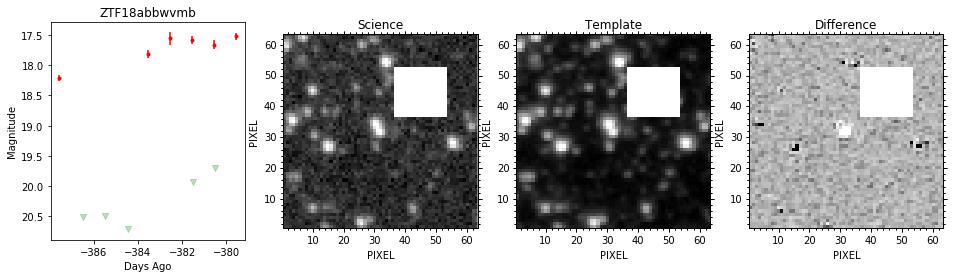

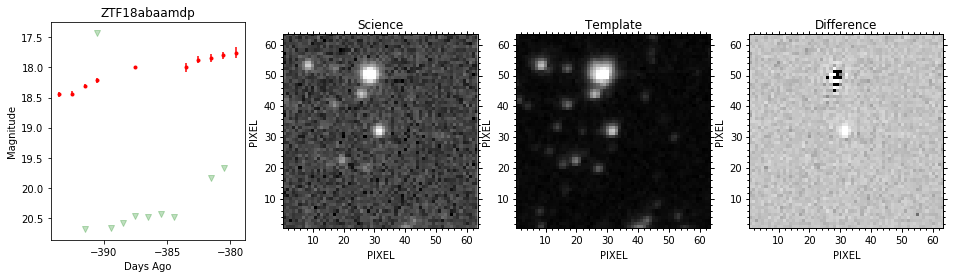

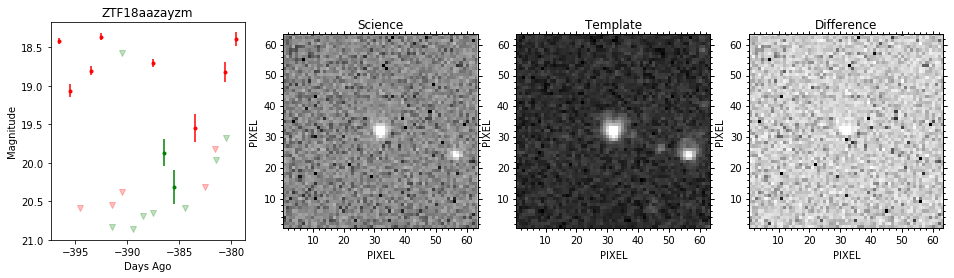

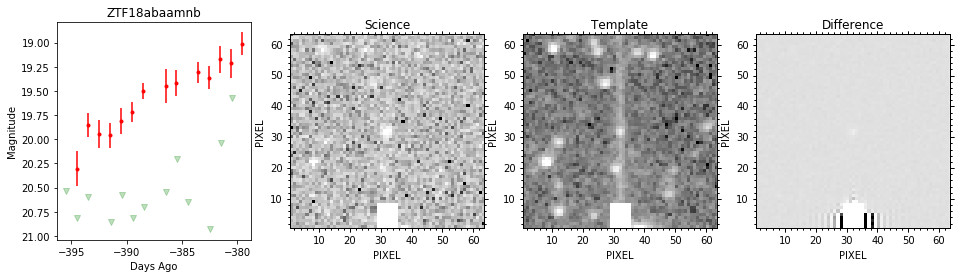

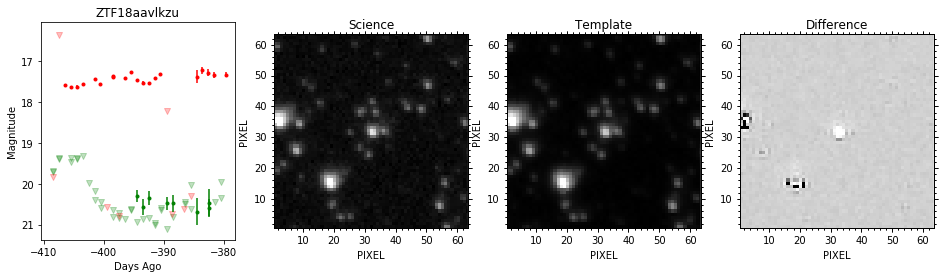

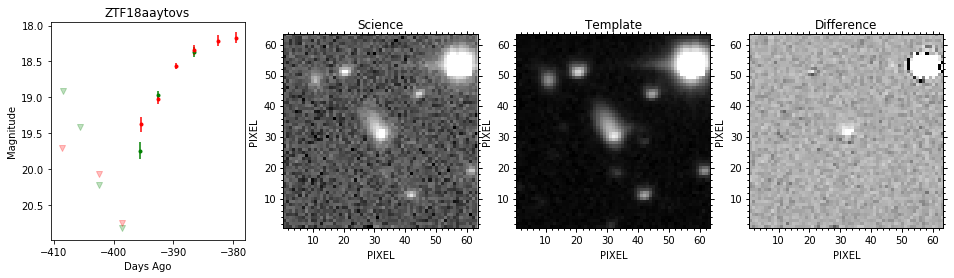

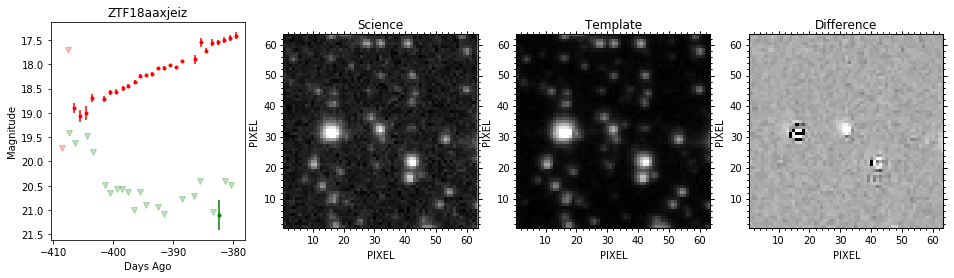

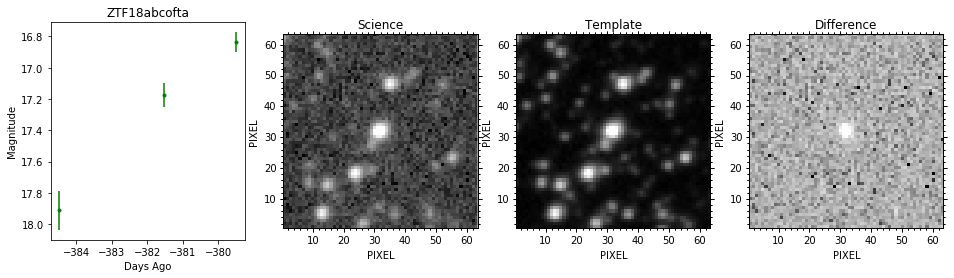

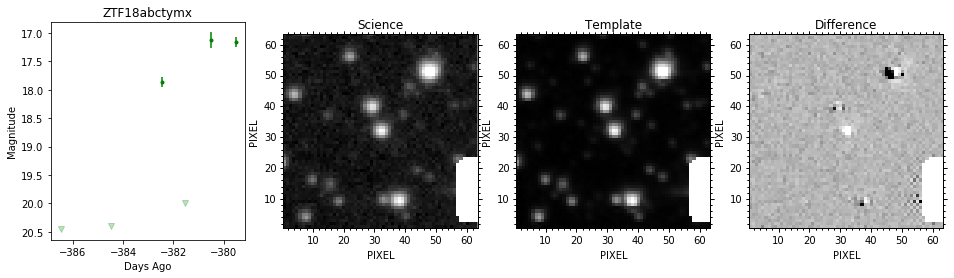

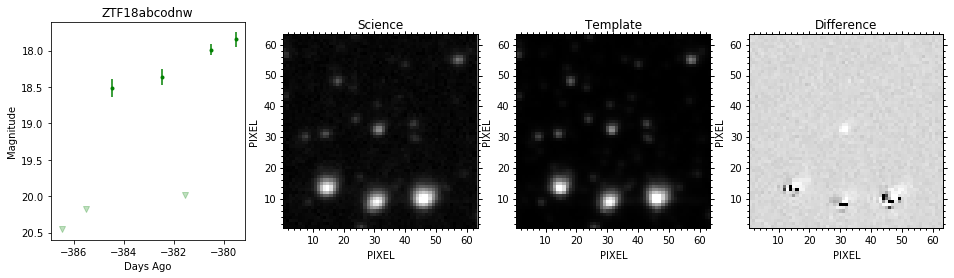

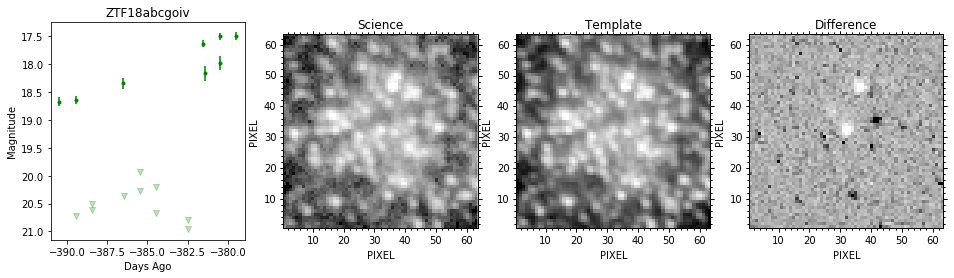

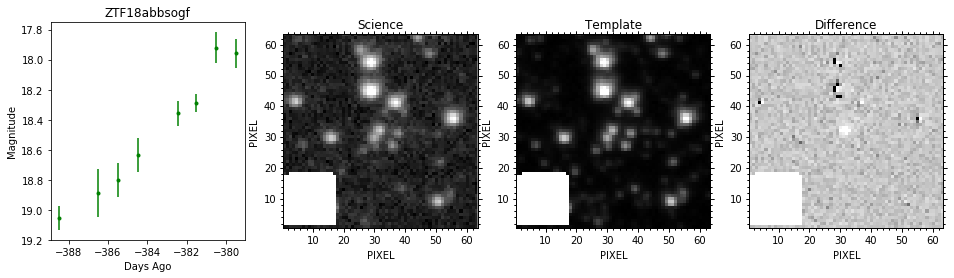

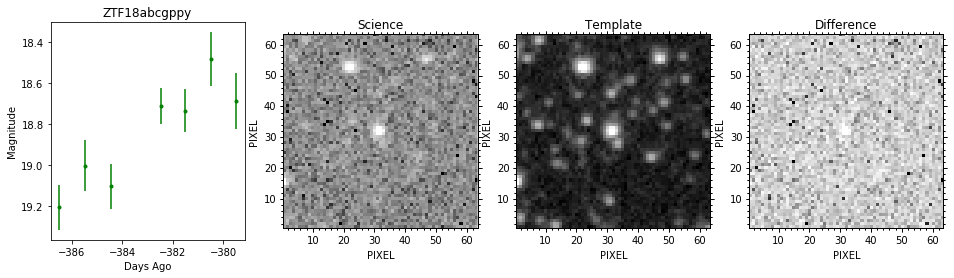

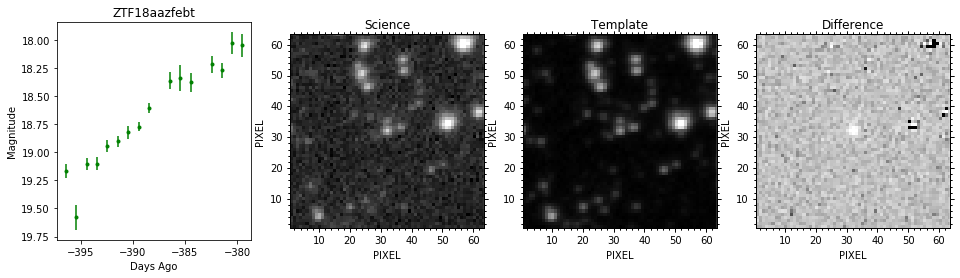

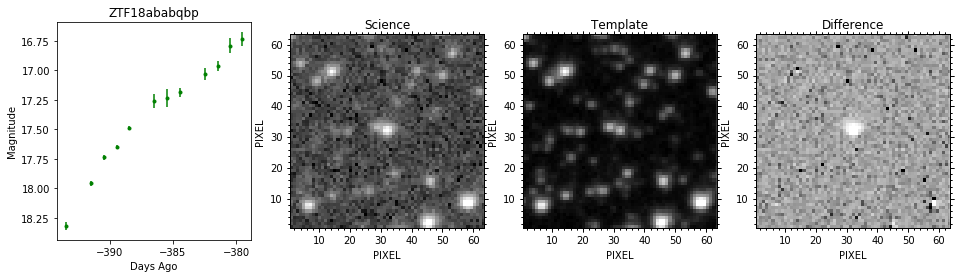

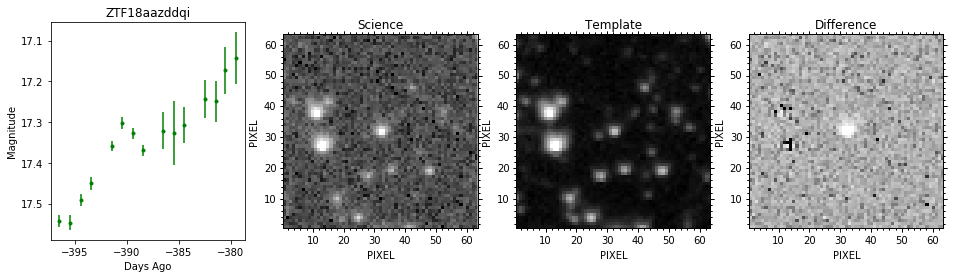

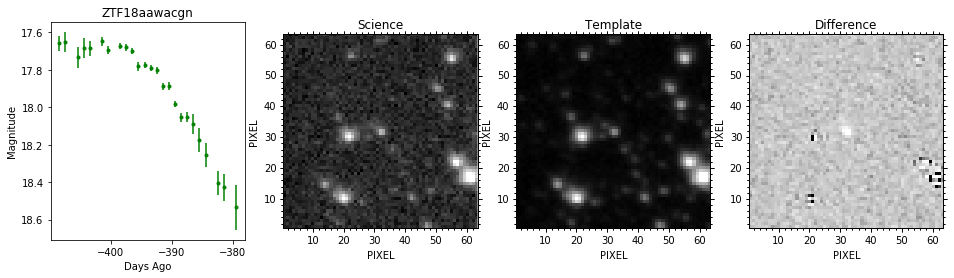

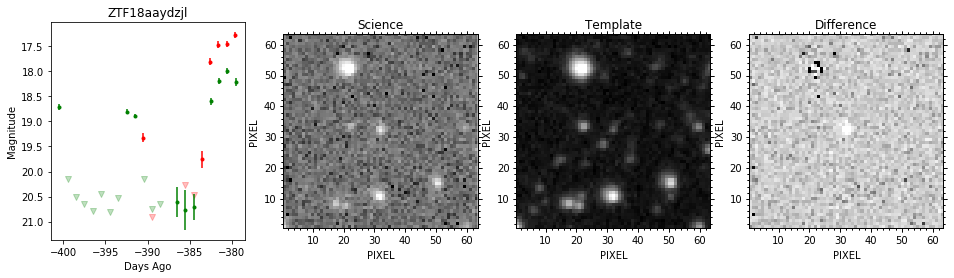

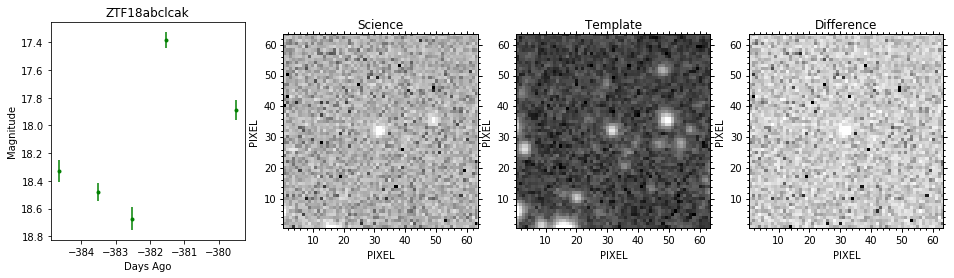

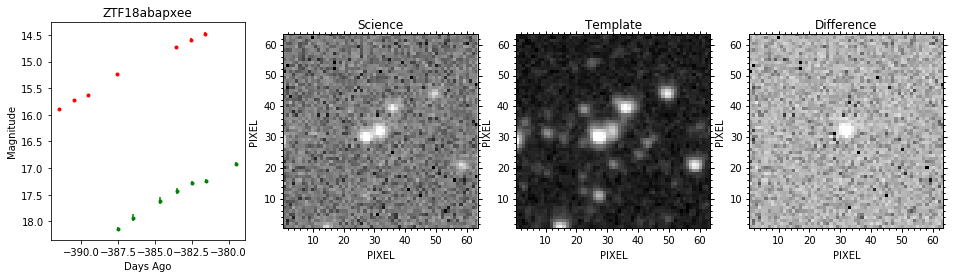

In [80]:
for packet in transient_alerts:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        show_all(packet)

In [5]:
%pwd


'C:\\Users\\Mikha_PC\\Documents\\1Masters\\GROWTH\\@Seattle'